In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt


In [3]:
import mascado.utility.zemax as zemax
import mascado.utility.plotting as plotting
import mascado.distortions.analysis as analysis
from mascado.distortions.polynomials import PolyVectorField, Legendre
from mascado.distortions.polyfit import polyfit_svd
import mascado.utility.affine as affine



In [4]:
from pathlib import Path
import os

import pandas
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
import numpy
np = numpy

# Open Questions:

- Are the `predicted` and `real` coordinates indeed on the detector plane?
- Can they therefore be easily converted to pixel coordinates and back?
- Are the `predicted` coordinates in effect the true coordinates that we want to end up with after the correction?

# General Idea of Astrometric Calibration

The astrometric distortions of MICADO will be calibrated by using a warm astrometric mask (WAM). The WAM is placed in the filter wheel and contains a grid of pinholes of which the position is known. The light from the flat lamp passes through the WAM and the pinhole pattern is measured on the detectors.

An affine transformation relates the measured pinhole positions to the actual pinhole positions to first order. Left-over distortions are determined by fitting a 5-th order Legendre polynomial field. This polynomial is subsequently used to determine the distortion of actual sky observations.

This notebook shows that the MASCADO software can be used to fit this polynomial field and that the residual dispersion is well within 50 microarcseconds.

## Data in the Data Reduction Library

The following data products will be used in the MICADO Data Reduction Library, and will therefore be mocked in this notebook:
- `REF_WAM_CAT`: The reference catalogus with the fixed and known pinhole positions of the warm astrometric mask. (Assumed to be in degrees here.)
- `WAM_CAT`: Measure positions of the pinhole sources on the detector. (Assumed to be in mm here.)
- `PSMWARM_HDR`: The coefficients of the polynomial field modeling the distortions. Derived by corellating `REF_WAM_CAT` and `WAM_CAT` through MASCADO. (Not a catalog.)
- `SOURCES_CAT`: A source catalog with astronomical objects that need to be corrected by applying the model in `PSMWARM_HDR`.

## Coordinate Planes and Units

For simplicity we consider only 2 planes, with several possible units. The origin and orientation of the planes are approximately matching. Planes:
- Sky or mask plane: The position of the pinhole sources or astronomical objects on the sky. Units:
  - degree: degrees are only used when storing all data in files
  - arcsecond: the distortions are calculated in arcseconds
  - unitless: the sky positions are normalized to be within -1 and 1 because this is the domain of the Legendre polynomial field
- Detector plane. Units:
  - mm: everything is in millimeter
  - pixels: pixel coordinates are not used in this example.






# The Plan

We have a file with simulated pinhole mask data, generated by ZEMAX called `mockdata1.txt`. This file is used to generate `REF_WAM_CAT`, `WAM_CAT`, and `SOURCES_CAT`. (So our 'sources' happen to look very much like pinholes, what a coincidence!) Then `PSMWARM_HDR` is generated from `REF_WAM_CAT` and `WAM_CAT` and applied to `SOURCES_CAT` to model the distortions. `SOURCES_CAT` will also contain the 'true' source location, so we can estimate the correctness of the model.

`mockdata1.txt` has 13 * 13 = 169 rows representing pinholes (of which 10% is choosen to represent a celestial source) and contains the following columns:
- `i` and `j`: grid labels, which are ignored.
- `x-field` and `y-field`: reference locations of the pinholes (in degrees), which are the contents of `REF_WAM_CAT`.
- `r-field`: the radial distance of the pinholes, ignored.
- `x-predicted` and `y-predicted`: the desired 'true' locations of the pinholes/sources on the detector plane (in mm), not measurable, and therefore only used in the final comparison of the modelled distortions (and thus part of `SOURCES_CAT`).
- `x-real` and `y-real`: the 'measured' positions of the pinholes/sources on the detector plane (in mm), both used in `WAM_CAT` and `SOURCES_CAT`.
- `random`: not in the file, but added in this script to use different pinholes/sources for `REF_WAM_CAT` and `WAM_CAT`, and `SOURCES_CAT`.

A random 10% of the pinholes are selected to be 'sources', and are not used in fitting the model. These sources are considered to be celestial objects observed with exactly the same distortion pattern as the pinholes, and happen to look exactly like pinholes.

A pictorial representation how the three catalogs are constructed from `mockdata1.txt`. `x`s mean that the data is ignored. `random` is not part of the original catalog, and therefore detached in the figure.

    +-------+---------+---------+---------+-------------+-------------+--------+--------+ +--------+
    | i | j | x-field | y-field | r-field | x-predicted | y-predicted | x-real | y-real | | random |
    +-------+---------+---------+---------+-------------+-------------+--------+--------+ +--------+
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|   REF_WAM_CAT     |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|  WAM_CAT        | | < 0.9  |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|   152 pinholes    |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|  152 pinholes   | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx|                   |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                 | |        |
    |xxxxxxx+-------------------+xxxxxxxxx+---------------------------+-----------------+ +--------+
    |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                                             | |        |
    |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|   SOURCES_CAT                               | | >= 0.9 |
    |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                                             | |        |
    |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|   17 'sources'                              | |        |
    |xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx|                                             | |        |
    +-------------------------------------+---------------------------------------------+ +--------+
    
    





In [5]:
# Demo from André Boné
fn = Path(os.path.abspath('')).resolve().parent / "mockdata" / "mockdata1.txt"

# Reference catalog with pinhole locations in degree
fn_ref_wam_cat = "refwamcat.fits"

# Catalog with measured pinhole locations in mm
fn_wam_cat = "wamcat.fits"

# Catalog with 'sources', in degree
fn_sources_cat = "sourcecat.fits"

# Preparing Data

The data is prepared in order to run the model.

## Load Simualtion Data

In [6]:
# Load data
df1 = zemax.load_grid_data_variant("A", fn, encoding="latin-1")
df1

,i,j,x-field,y-field,r-field,x-predicted,y-predicted,x-real,y-real
0,-6.0,-6.0,-0.0075,-0.00750,0.010607,89.6109,89.5475,89.6505,89.5058
1,-6.0,-5.0,-0.0075,-0.00625,0.009763,89.6109,74.6229,89.6437,74.5820
2,-6.0,-4.0,-0.0075,-0.00500,0.009014,89.6109,59.6983,89.6363,59.6577
3,-6.0,-3.0,-0.0075,-0.00375,0.008385,89.6109,44.7738,89.6283,44.7331
4,-6.0,-2.0,-0.0075,-0.00250,0.007906,89.6109,29.8492,89.6197,29.8087
...,...,...,...,...,...,...,...,...,...
164,6.0,2.0,0.0075,0.00250,0.007906,-89.6109,-29.8492,-89.5788,-29.8814
165,6.0,3.0,0.0075,0.00375,0.008385,-89.6109,-44.7738,-89.5670,-44.8003
166,6.0,4.0,0.0075,0.00500,0.009014,-89.6109,-59.6983,-89.5546,-59.7170
167,6.0,5.0,0.0075,0.00625,0.009763,-89.6109,-74.6229,-89.5415,-74.6313


## MASCADO analyze

For completeness, show the main plot from `mascado_analyze`. This data is not used directly in the rest of the notebook.

Fitting 0. order Legendre polynomial
  169 2D data points, 2 parameters: over-determined
  Condition number: 1 (max 100)
  Residual variance: 3.71e-05
  Residual RMS: 0.00607 arcseconds
Fitting 1. order Legendre polynomial
  169 2D data points, 6 parameters: over-determined
  Condition number: 1.6 (max 100)
  Residual variance: 3.76e-05
  Residual RMS: 0.00607 arcseconds
Fitting 2. order Legendre polynomial
  169 2D data points, 12 parameters: over-determined
  Condition number: 2.6 (max 100)
  Residual variance: 9.62e-07
  Residual RMS: 0.000963 arcseconds
Fitting 3. order Legendre polynomial
  169 2D data points, 20 parameters: over-determined
  Condition number: 3.15 (max 100)
  Residual variance: 1.52e-10
  Residual RMS: 1.2e-05 arcseconds
Fitting 4. order Legendre polynomial
  169 2D data points, 30 parameters: over-determined
  Condition number: 3.91 (max 100)
  Residual variance: 7.17e-11
  Residual RMS: 8.08e-06 arcseconds
Fitting 5. order Legendre polynomial
  169 2D data poin

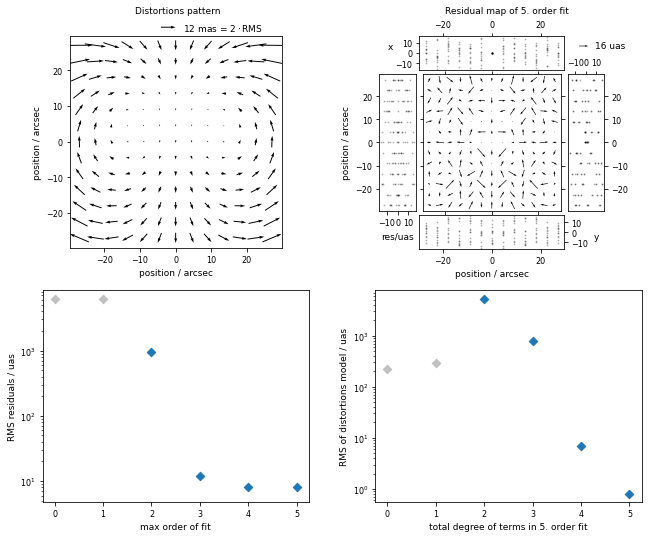

In [7]:
_atrafo, posnormscale, positions, (distortions,) = zemax.distortions_on_sky([df1], scale=1.0)
plotting.set_fontsize(medium=9)
fig = plt.figure(figsize=(8*1.3, 6*1.3))
vf = plotting.make_grid_analysis(fig, positions, distortions, posnormscale, 5, 1e2)


## Derive Statistics

The full dataset is used to derive statistics for two things:

- The scaling factors and offsets (`posscale`, `posshift`) to go from detector plane in arcseconds to normalized coordinates in the range (-1, 1). These scaling factors have to be the same for both `WAM_CAT` and `SOURCES_CAT`, and it would be best if these are the same for *all* of those. So they should be externally defined and should be hardcoded somewhere.  
- Manual platescales (`platescale_x` and `platescale_y`) and affine transformation (`atrafo_manual`), which are only used to calculate the 'true' distortions from `x-predicted` and `y-predicted` in `SOURCES_CAT`. These are derived independently from the model fit.


In [8]:
x_pred_max = df1['x-predicted'].max()
x_pred_min = df1['x-predicted'].min()

x_field_max = df1['x-field'].max()
x_field_min = df1['x-field'].min()

platescale_x = (x_field_max - x_field_min) / (x_pred_max - x_pred_min) * 3600

print(x_pred_min, x_pred_max)
print(x_field_min, x_field_max)
print(platescale_x)

-89.6109 89.6109
-0.0075 0.0075
0.3013026317110976


In [9]:
y_pred_max = df1['y-predicted'].max()
y_pred_min = df1['y-predicted'].min()

y_field_max = df1['y-field'].max()
y_field_min = df1['y-field'].min()

platescale_y = (y_field_max - y_field_min) / (y_pred_max - y_pred_min) * 3600

print(y_pred_min, y_pred_max)
print(y_field_min, y_field_max)
print(platescale_y)

-89.5475 89.5475
-0.0075 0.0075
0.30151595521929697


In [10]:
atrafo_manual = numpy.array([
    [-platescale_x, 0., 0.],
    [0., -platescale_y, 0.],
    [0., 0., 1.],
])
atrafo_manual

array([[-0.30130263,  0.        ,  0.        ],
       [ 0.        , -0.30151596,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [11]:
ppp = 3600 * numpy.array([x_field_min, x_field_max, y_field_min, y_field_min])
posmin, posmax = np.min(ppp), np.max(ppp)
posscale = (posmax - posmin) / 2
posshift = (posmax + posmin) / 2
print(posscale, posshift)



27.0 0.0


## Split the Data

The data is split into `REF_WAM_CAT`, `WAM_CAT`, and `SOURCES_CAT`.

In [12]:
df = df1.assign(random=numpy.random.rand(len(df1)))

In [13]:
df_pinholes = df.query("random < 0.9")
df_sources = df.query("random >= 0.9")
len(df_pinholes) + len(df_sources)

169

In [14]:
units = {
    'i': u.dimensionless_unscaled,
    'j': u.dimensionless_unscaled,
    'x-field': u.degree,
    'y-field': u.degree,
    'x-predicted': u.mm,
    'y-predicted': u.mm,
    'x-real': u.mm,
    'y-real': u.mm,
}

In [15]:
df_ref_wam_cat = df_pinholes.loc[:, ['x-field', 'y-field']]
df_ref_wam_cat

,x-field,y-field
0,-0.0075,-0.00750
1,-0.0075,-0.00625
2,-0.0075,-0.00500
3,-0.0075,-0.00375
4,-0.0075,-0.00250
...,...,...
164,0.0075,0.00250
165,0.0075,0.00375
166,0.0075,0.00500
167,0.0075,0.00625


In [16]:
ref_wam_cat = Table.from_pandas(df_ref_wam_cat, units=units)

/home/hugo/miniconda3/envs/micadowise2/lib/python3.9/site-packages/astropy/table/table.py:3536: UserWarning: `units` contains additionial columns: {'i', 'y-real', 'y-predicted', 'x-predicted', 'j', 'x-real'}
  warnings.warn('`units` contains additionial columns: {}'.format(


In [17]:
ref_wam_cat

x-field,y-field
deg,deg
float64,float64
-0.0075,-0.0075
-0.0075,-0.00625
-0.0075,-0.005
-0.0075,-0.00375
-0.0075,-0.0025
-0.0075,-0.00125
-0.0075,0.0
-0.0075,0.00125


In [18]:
ref_wam_cat.write(fn_ref_wam_cat, overwrite=True)

In [19]:
df_wam_cat = df_pinholes.loc[:, ['x-real', 'y-real']]
wam_cat = Table.from_pandas(df_wam_cat, units=units)
wam_cat.write(fn_wam_cat, overwrite=True)

/home/hugo/miniconda3/envs/micadowise2/lib/python3.9/site-packages/astropy/table/table.py:3536: UserWarning: `units` contains additionial columns: {'x-field', 'i', 'y-field', 'x-predicted', 'j', 'y-predicted'}
  warnings.warn('`units` contains additionial columns: {}'.format(


In [20]:
sources_cat = Table.from_pandas(df_sources, units=units)
sources_cat.write(fn_sources_cat, overwrite=True)

# Derive the Distortion Model

## Read the Data Back in

The data is read in as-if it was just observed. Datasets have a `2` as prefix to ensure that they are independent from the above.

The only information kept from above are
- `posscale` and `posshift`, which are supposedly static, to convert to unitless (-1, 1) coordinates


In [21]:
ref_wam_cat2 = Table.read(fn_ref_wam_cat)
df_ref_wam_cat2 = ref_wam_cat2.to_pandas()
df_ref_wam_cat2

,x-field,y-field
0,-0.0075,-0.00750
1,-0.0075,-0.00625
2,-0.0075,-0.00500
3,-0.0075,-0.00375
4,-0.0075,-0.00250
...,...,...
151,0.0075,0.00250
152,0.0075,0.00375
153,0.0075,0.00500
154,0.0075,0.00625


In [22]:
wam_cat2 = Table.read(fn_wam_cat)
df_wam_cat2 = wam_cat2.to_pandas()
df_wam_cat2

,x-real,y-real
0,89.6505,89.5058
1,89.6437,74.5820
2,89.6363,59.6577
3,89.6283,44.7331
4,89.6197,29.8087
...,...,...
151,-89.5788,-29.8814
152,-89.5670,-44.8003
153,-89.5546,-59.7170
154,-89.5415,-74.6313


## Derive Distortions

Convert the data to the same coordinate system and derive the distortions.

In [23]:
# Similar to what distortions_on_sky() does.

# Get the reference pinhole positions on the mask/sky plane.
refpos_degree = df_ref_wam_cat2.loc[df_ref_wam_cat2.index, ['x-field', 'y-field']].values
# Convert degree to arcsec.
refpos_arcsec = refpos_degree * 3600

# Get the 'measured' pinhole positions on the detector plane.
realpos_mm = df_wam_cat2.loc[df_wam_cat2.index, ['x-real', 'y-real']].values

# Derive the affine transformation to go from detector plane (in mm) to mask/sky plane (in arcsec).
atrafo = affine.affine_lstsq(realpos_mm, refpos_arcsec)

atrafo

array([[-3.01335501e-01, -6.16452707e-06,  4.96146813e-05],
       [-3.07598418e-06, -3.01562019e-01, -2.28156149e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [24]:
# Convert measured positions to mask/sky plane (in arcsec).
skypos_arcsec = affine.affine_trafo(realpos_mm, atrafo)

# Measure the distortions of the pinholes.
distortions_pinholes = skypos_arcsec - refpos_arcsec

distortions_pinholes

array([[-1.53805171e-02,  5.89289510e-03],
       [-1.32394375e-02,  6.34417845e-03],
       [-1.09175535e-02,  6.94624466e-03],
       [-8.41486643e-03,  7.63878131e-03],
       [-5.73137925e-03,  8.27100741e-03],
       [-2.83695968e-03,  8.78261085e-03],
       [ 2.38256668e-04,  9.07332196e-03],
       [ 3.49426732e-03,  9.02176203e-03],
       [ 6.96120400e-03,  8.53821665e-03],
       [ 1.06089309e-02,  7.51186149e-03],
       [ 1.44374455e-02,  5.82207172e-03],
       [ 1.84768802e-02,  3.40853527e-03],
       [-1.36692872e-02,  1.38526136e-03],
       [-1.18898072e-02,  1.98732202e-03],
       [-9.92952210e-03,  2.77032175e-03],
       [-7.84870161e-03,  3.61363511e-03],
       [-5.58708043e-03,  4.42679411e-03],
       [-3.17479397e-03,  5.11932984e-03],
       [-6.11844753e-04,  5.56760188e-03],
       [ 2.13189911e-03,  5.69018878e-03],
       [ 5.02630141e-03,  5.35741857e-03],
       [ 8.07136099e-03,  4.51199446e-03],
       [ 1.12972083e-02,  3.00313576e-03],
       [ 1.

## Derive the Model

Fit the polynomial field.

In [25]:
# normalize positions, using hardcoded values
positions_pinholes = (refpos_arcsec - posshift) / posscale

In [26]:
maxorder = 5
poly=Legendre
maxcondition=1e2

In [27]:
vf = PolyVectorField(poly(maxorder))
params, residuals, hb1 = polyfit_svd(vf, positions_pinholes, distortions_pinholes,
                                   maxcondition=maxcondition)
vf.set_params(params)
modelrms = analysis.analyze_contributions_over_order(vf)


  156 2D data points, 42 parameters: over-determined
  Condition number: 5.26 (max 100)
  Residual variance: 7.35e-11
  0.000288 arcseconds RMS distortions in 0. degree terms
  0.000422 arcseconds RMS distortions in 1. degree terms
   0.00525 arcseconds RMS distortions in 2. degree terms
  0.000803 arcseconds RMS distortions in 3. degree terms
  6.87e-06 arcseconds RMS distortions in 4. degree terms
  9.84e-07 arcseconds RMS distortions in 5. degree terms


In [28]:
# Show the full parameters.
print(vf.paramcount, len(params))
params

42 42


array([ 4.95617816e-05,  5.51814069e-04, -4.86205930e-07, -5.07050214e-07,
       -4.13833881e-07, -4.14585556e-07, -7.74699911e-05, -1.84604362e-02,
       -2.29601642e-03, -1.77254755e-05,  1.92668618e-06,  1.25717917e-07,
       -8.65183620e-07, -1.43516898e-06, -7.87759727e-07, -1.25049150e-03,
       -1.68885875e-05,  4.81763502e-07,  1.64068026e-07,  2.78516527e-07,
       -7.63278761e-07, -4.04954835e-04,  8.12647188e-04, -4.01269198e-03,
       -1.47024441e-03, -1.38409510e-05, -2.84234904e-06,  2.75574749e-04,
       -8.30682061e-07,  8.62587430e-07,  6.31194272e-07, -2.75669017e-07,
        7.73946270e-03, -2.22626102e-03, -3.02514880e-05, -5.02725812e-06,
       -2.08348766e-08,  2.04779345e-06,  5.59219506e-07, -7.96363862e-07,
        8.87515979e-09,  6.78999092e-07])

In [29]:
# Show the parameters as coefficients to the Legendre polynomials.
vf.xpoly.params_to_coeff(vf.xpoly.params)

array([[ 4.95617816e-05,  5.51814069e-04, -4.86205930e-07,
        -5.07050214e-07, -4.13833881e-07, -4.14585556e-07],
       [-7.74699911e-05, -1.84604362e-02, -2.29601642e-03,
        -1.77254755e-05,  1.92668618e-06,  0.00000000e+00],
       [ 1.25717917e-07, -8.65183620e-07, -1.43516898e-06,
        -7.87759727e-07,  0.00000000e+00,  0.00000000e+00],
       [-1.25049150e-03, -1.68885875e-05,  4.81763502e-07,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.64068026e-07,  2.78516527e-07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.63278761e-07,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [30]:
vf.ypoly.params_to_coeff(vf.ypoly.params)

array([[-4.04954835e-04,  8.12647188e-04, -4.01269198e-03,
        -1.47024441e-03, -1.38409510e-05, -2.84234904e-06],
       [ 2.75574749e-04, -8.30682061e-07,  8.62587430e-07,
         6.31194272e-07, -2.75669017e-07,  0.00000000e+00],
       [ 7.73946270e-03, -2.22626102e-03, -3.02514880e-05,
        -5.02725812e-06,  0.00000000e+00,  0.00000000e+00],
       [-2.08348766e-08,  2.04779345e-06,  5.59219506e-07,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.96363862e-07,  8.87515979e-09,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.78999092e-07,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Storing the Coefficients

At this point the coefficients (`params`) should be stored in a file (as `PSMWARM_HDR`). This is skipped in this proof-of-concept.

# Apply the Distortion Model

Now apply the distortion model to the 'measured' 'sources' in order to correct for the distortions.

## Read the Data Back in

The data is read in as-if it was just observed. Datasets have a `2` as prefix to ensure that they are independent from the above.

The only information kept from above are
- `posscale` and `posshift`, which are supposedly static, to convert to unitless (-1, 1) coordinates
- `platescale_x` and `platescale_y`, which are only used to derive the 'true' distortions to compare with
- `params`, which should be read from `PSMWARM_HDR`.


In [31]:
sources_cat2 = Table.read(fn_sources_cat)
df_sources_cat2 = sources_cat2.to_pandas()

## Apply Model

In [32]:
# Convert focal plane positions (in mm) to sky positions (in arcsec) and normalize them.
realpos_sources_mm = df_sources_cat2.loc[df_sources_cat2.index, ['x-real', 'y-real']].values
skypos_sources_arcsec = affine.affine_trafo(realpos_sources_mm, atrafo)
positions_sources_normalized = (skypos_sources_arcsec - posshift) / posscale


vf2 = PolyVectorField(poly(maxorder))
vf2.set_params(params)
distortions_sources_fitted = vf2.full_model(positions_sources_normalized, *params)


In [33]:
distortions_sources_fitted

array([[ 2.26905854e-02,  9.23132336e-05],
       [ 1.21584361e-03,  2.96292675e-03],
       [ 1.41549980e-02, -4.36397019e-03],
       [-7.98932434e-03, -4.29864221e-03],
       [-2.61269541e-03, -2.06889342e-04],
       [-4.77350431e-03, -5.15673726e-03],
       [-2.09579452e-03, -5.05457650e-03],
       [-3.18910639e-04, -6.60234440e-03],
       [-1.34675444e-04, -4.18264360e-03],
       [ 4.13584099e-03, -4.97094115e-03],
       [-5.35563941e-03,  2.43519943e-03],
       [-1.04622438e-02,  3.46406653e-03],
       [-1.35925341e-04,  9.62557309e-03]])

## Compare with 'True' Distortions

In [34]:
# Read in the predicted true data in focal plane coordinates (in mm).
predictedpos_sources_mm = df_sources_cat2.loc[df_sources_cat2.index, ['x-predicted', 'y-predicted']].values
# Convert to sky posititons in arcsec. Done manually, to prevent any collusion with the model.
predictedskypos_sources_arcsec = predictedpos_sources_mm.copy()
predictedskypos_sources_arcsec[:,0] *= -platescale_x 
predictedskypos_sources_arcsec[:,1] *= -platescale_y
distortions_sources_predicted = skypos_sources_arcsec - predictedskypos_sources_arcsec
distortions_sources_predicted

array([[ 0.02272723,  0.00012047],
       [ 0.00122155,  0.00295672],
       [ 0.01418676, -0.00437149],
       [-0.00797009, -0.00428875],
       [-0.00259988, -0.00021188],
       [-0.00476558, -0.00515358],
       [-0.00207333, -0.00502326],
       [-0.00031843, -0.00659963],
       [-0.0001344 , -0.00416919],
       [ 0.00412879, -0.00496974],
       [-0.00536459,  0.00243739],
       [-0.01047691,  0.00347232],
       [-0.00013855,  0.00962454]])

In [35]:
# The relative differences.
distortions_sources_fitted / distortions_sources_predicted

array([[0.99838755, 0.76626862],
       [0.99533144, 1.00209957],
       [0.99776083, 0.99828022],
       [1.00241339, 1.00230621],
       [1.00492877, 0.97642291],
       [1.00166191, 1.00061338],
       [1.01083347, 1.00623503],
       [1.00150859, 1.00041182],
       [1.00203043, 1.00322679],
       [1.00170804, 1.00024083],
       [0.99833144, 0.99910109],
       [0.99860042, 0.99762395],
       [0.98104345, 1.00010716]])

In [36]:
# The residual distortion in microarcseconds.
residual_distortion_arcsec = distortions_sources_fitted - distortions_sources_predicted
residual_distortion_microarcsec = residual_distortion_arcsec * 10**6
residual_distortion_microarcsec

array([[-36.64646387, -28.1578796 ],
       [ -5.70286391,   6.2078279 ],
       [-31.76663157,   7.51801813],
       [-19.2349261 ,  -9.89077208],
       [-12.81422793,   4.99563002],
       [ -7.91999584,  -3.16109724],
       [-22.46139384, -31.32013772],
       [ -0.48038087,  -2.71788154],
       [ -0.27289473, -13.45311007],
       [  7.05212051,  -1.1968757 ],
       [  8.95113959,  -2.19099081],
       [ 14.66323548,  -8.2503851 ],
       [  2.62646352,   1.03134229]])

In [37]:
residual_distortion_abs_microarcsec = numpy.sqrt((residual_distortion_microarcsec**2).sum(axis=1))
residual_distortion_abs_microarcsec

array([46.21503541,  8.42969656, 32.6441339 , 21.62891015, 13.7535725 ,
        8.52753598, 38.54173374,  2.7600083 , 13.45587761,  7.15296548,
        9.21538608, 16.82496149,  2.82169764])

In [38]:
# Average residual distortion in microarcseconds.
residual_distortion_abs_microarcsec.mean()

17.07473191086658

The residual distortion should be around 15 microarcseconds, well within the maximum of 50 microarseconds.

## Actually Correcting the Sky Positions

At this point the sky positions of the measured source positions could be corrected.